# 4MLSP - Graded project
## Anallyse du dataset Titanic
-----------------------------------------------------------
* Edgar Weber
* Mathis Roger

![alt text](https://i.ytimg.com/vi/njeHnXN_aFE/maxresdefault.jpg)

### Import des librairies

In [1]:
# Manipulation des données
import pandas as pd
import numpy as np

# Visualisation des données
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
%matplotlib inline

# Préprocessing des données
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import  StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier

# Metrics
from sklearn.metrics import recall_score,  f1_score, plot_confusion_matrix

------------------------------------------
### 1 - Chargement du dataset
[Lien du dataset](https://canvas.supinfo.com/courses/73/files/49067/download)

In [2]:
df = pd.read_csv('./titanic.csv')
df.head()

pclass  survived                                             name     sex  \
0       1         1                    Allen, Miss. Elisabeth Walton  female   
1       1         1                   Allison, Master. Hudson Trevor    male   
2       1         0                     Allison, Miss. Helen Loraine  female   
3       1         0             Allison, Mr. Hudson Joshua Creighton    male   
4       1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female   

     age  sibsp  parch  ticket      fare    cabin embarked boat   body  \
0  29.00      0      0   24160  211.3375       B5        S    2    NaN   
1   0.92      1      2  113781  151.5500  C22 C26        S   11    NaN   
2   2.00      1      2  113781  151.5500  C22 C26        S  NaN    NaN   
3  30.00      1      2  113781  151.5500  C22 C26        S  NaN  135.0   
4  25.00      1      2  113781  151.5500  C22 C26        S  NaN    NaN   

                         home.dest  
0                     St Louis, MO  
1  Montreal, PQ / Chesterville, ON  
2  Montreal, PQ / Chesterville, ON  
3  Montreal, PQ / Chesterville, ON  
4  Montreal, PQ / Chesterville, ON

----------------------
### 2 - Exploration du dataset

In [74]:
df.describe()

pclass     survived          sex          age        sibsp  \
count  1309.000000  1309.000000  1309.000000  1046.000000  1309.000000   
mean      2.294882     0.381971     0.355997    29.881138     0.498854   
std       0.837836     0.486055     0.478997    14.413493     1.041658   
min       1.000000     0.000000     0.000000     0.170000     0.000000   
25%       2.000000     0.000000     0.000000    21.000000     0.000000   
50%       3.000000     0.000000     0.000000    28.000000     0.000000   
75%       3.000000     1.000000     1.000000    39.000000     1.000000   
max       3.000000     1.000000     1.000000    80.000000     8.000000   

             parch         fare     embarked  
count  1309.000000  1308.000000  1307.000000  
mean      0.385027    33.295479     0.394797  
std       0.865560    51.758668     0.653817  
min       0.000000     0.000000     0.000000  
25%       0.000000     7.895800     0.000000  
50%       0.000000    14.454200     0.000000  
75%       0.000000    31.275000     1.000000  
max       9.000000   512.329200     2.000000

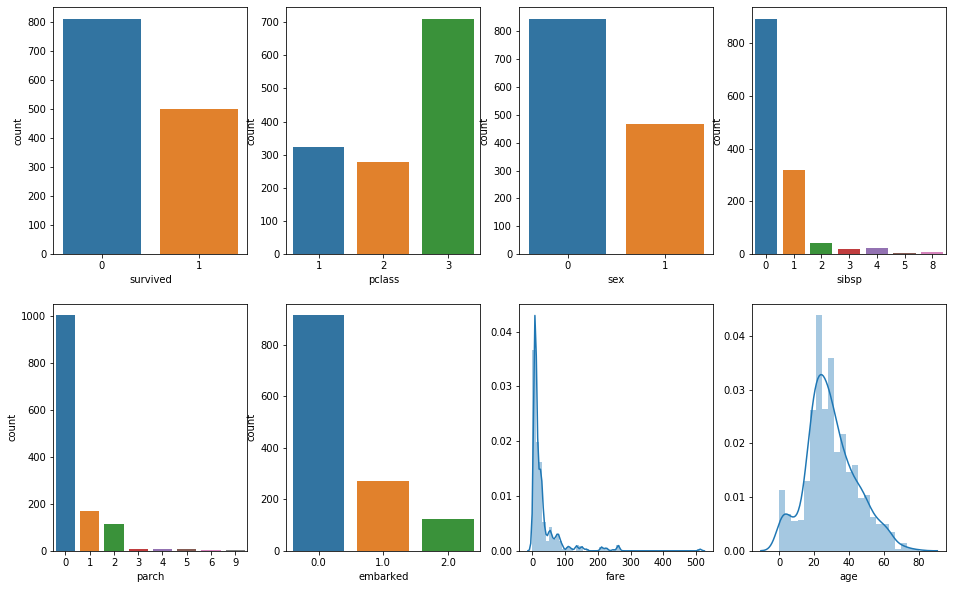

In [79]:
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
sns.countplot('survived',data=df,ax=axes[0,0])
sns.countplot('pclass',data=df,ax=axes[0,1])
sns.countplot('sex',data=df,ax=axes[0,2])
sns.countplot('sibsp',data=df,ax=axes[0,3])
sns.countplot('parch',data=df,ax=axes[1,0])
sns.countplot('embarked',data=df,ax=axes[1,1])
sns.distplot(df['fare'], kde=True,ax=axes[1,2])
sns.distplot(df['age'].dropna(),kde=True,ax=axes[1,3])

###### Distribution des ages

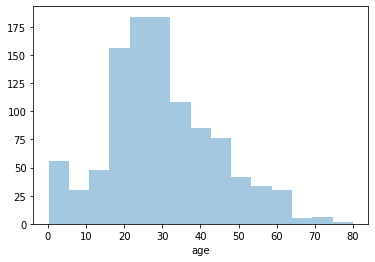

In [7]:
sns.distplot(df['age'].dropna(), bins=15, kde=False)

###### Distribution des survies par age

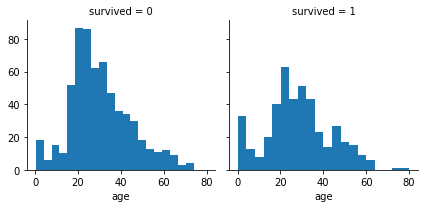

In [83]:
g = sns.FacetGrid(df, col='survived')
g.map(plt.hist, 'age', bins=20)

###### Matrice de correlation
Cette matrice nous permet de découvrir des relations entre les variables

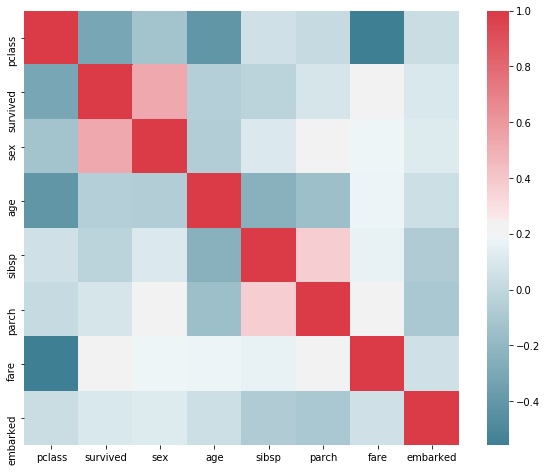

In [82]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr,
            mask=np.zeros_like(corr, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

---
### 3 - Préprocessing des données



In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


Nous pouvons remarquer qu'il manque des valeurs pour :
* l'age
* la cabine
* le lieu d'embarquement
* le radeau de survie
* le numéro d'identification du corps
* la destination


Concernant l'age, nous allons remplacer les valeurs manquantes vu que celles-i sont peu nombreuses.

Pour le numéro du radeau de survie, nous allons le transformer en valeur catégorique (0 = pas de radeau, 1 = radeau) car cette valeur influe grandement la survie du passager.

Nous allons aussi supprimer certaines collonnes n'étant pas pertinentes pour l'analyse des données, ou ayant trop de données manquantes :
* le nom
* le numéro de ticket
* la cabine
* le numéro d'identification du corps
* la destination


In [10]:
df = df.drop(['name', 'ticket', 'cabin', 'body'], axis=1)
df.head()

pclass  survived     sex    age  sibsp  parch      fare embarked boat  \
0       1         1  female  29.00      0      0  211.3375        S    2   
1       1         1    male   0.92      1      2  151.5500        S   11   
2       1         0  female   2.00      1      2  151.5500        S  NaN   
3       1         0    male  30.00      1      2  151.5500        S  NaN   
4       1         0  female  25.00      1      2  151.5500        S  NaN   

                         home.dest  
0                     St Louis, MO  
1  Montreal, PQ / Chesterville, ON  
2  Montreal, PQ / Chesterville, ON  
3  Montreal, PQ / Chesterville, ON  
4  Montreal, PQ / Chesterville, ON

In [59]:
numeric_transformer = Pipeline(steps=
    [('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', StandardScaler())]
                              )

categorical_transformer = Pipeline(steps=
    [('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('onehot',OneHotEncoder(handle_unknown='ignore'))]
                                  )

On liste les valeur numérique et catégoriques que nous allons transformer

In [60]:
numeric_features = ['age', 'fare']
categorical_features = ['embarked', 'sex', 'pclass', 'boat', 'home.dest']

In [61]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    sparse_threshold=0
)


### 4 - Découpage du dataset

Nous allons désormais séparer le dataset en quatre parties
* X corresponds aux caractéristiques qui nous permettent d'entrainer le modèle
* Y correspond à la caractéristique que nous souhaitons prédire, dans notre cas si le passager à survécu ou non

Nous divisons ensuite ces deux échantillons respectifs en deux parties :
   * Une servant à entrainer le modèle
   * Une servant à le tester

In [62]:
X = df.drop(['survived'], axis=1)
Y = pd.concat([df['survived']], axis=1, keys='survived')
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=42)

---
# Test des différents algorithmes

Dans cette section, nous allons tester notre modèle avec une selection d'algorithmes afin de savoir lequelle est le plus performant afin de prédire la survie des passagers. 

Afin de tester au mieux chaque algorithme, nous utilisons une technique de réglage des hyper paramètres appellé Grid Search CV. Aussi, nous fournissons le score, le score F1, le recall, la matrice de confusion et les meilleurs paramètres du Grid Search

### Ton PC =>
![Ton PC](https://media.giphy.com/media/APH2yVA1J0EWA/giphy.gif)


### 5 - K-Nearest Neighbors

In [63]:
clfknn = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', KNeighborsClassifier(algorithm='brute'))])

params = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__n_neighbors': list(range(1, 31)),
    'classifier__weights': ['uniform', 'distance']
}

gsknn = GridSearchCV(estimator=clfknn, param_grid=params, cv=5)
gsknn.fit(x_train, y_train.values.ravel())
prediction = gsknn.predict(x_test)
print("Meilleur score avec l'algorithme KNN : {}".format(gsknn.score(x_test, y_test)))
print("model score : {}".format(gsknn.score(x_test, y_test)))
print('f1 score : {}'.format(f1_score(y_test, prediction)))
print('recall : {}'.format(recall_score(y_test, prediction)))
print('meilleurs parametres : {}'.format(gsknn.best_params_))

Meilleur score avec l'algorithme KNN : 0.8905852417302799
model score : 0.8905852417302799
f1 score : 0.8599348534201954
recall : 0.7810650887573964
meilleurs parametres : {'classifier__n_neighbors': 3, 'classifier__weights': 'uniform', 'preprocessor__num__imputer__strategy': 'median'}


In [34]:
plot_confusion_matrix(gsknn, x_test, y_test)

### 6 - Support Vector Machine

In [35]:
clfsvm = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', SVC())])

params = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__kernel': ['rbf', 'linear', 'sigmoid', 'poly'],
    'classifier__C': [1, 10]
#     Bon j'ai commenté le dernier paramètre après 15 min de calculs
#     'classifier__gamma': [0.1, 1, 10]
}

clfsvm.fit(x_train, y_train.values.ravel())

gssvm = GridSearchCV(estimator=clfsvm, param_grid=params)
gssvm.fit(x_train, y_train.values.ravel())
prediction = gssvm.predict(x_test)
print("model score : {}".format(gssvm.score(x_test, y_test)))
print('f1 score : {}'.format(f1_score(y_test, prediction)))
print('recall : {}'.format(recall_score(y_test, prediction)))
print('meilleurs paramètres : {}'.format(gssvm.best_params_))

model score : 0.9465648854961832
f1 score : 0.9341692789968652
recall : 0.8816568047337278
meilleurs paramètres : {'classifier__C': 1, 'classifier__kernel': 'linear', 'preprocessor__num__imputer__strategy': 'mean'}


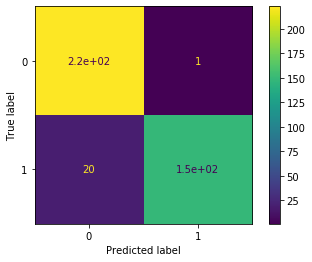

In [75]:
plot_confusion_matrix(gssvm, x_test, y_test)

### 7 - Linear Discriminant

In [71]:
clfld = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', LinearDiscriminantAnalysis())])

params = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'preprocessor__sparse_threshold': [0],
    'classifier__n_components': [1]
}

clfld.fit(x_train, y_train.values.ravel())

gsld = GridSearchCV(estimator=clfld, param_grid=params)
gsld.fit(x_train, y_train.values.ravel())
prediction = gsld.predict(x_test)
print("model score : {}".format(clfld.score(x_test, y_test)))
print('f1 score : {}'.format(f1_score(y_test, prediction)))
print('recall : {}'.format(recall_score(y_test, prediction)))
print('meilleurs paramètres : {}'.format(gsld.best_params_))

model score : 0.9465648854961832
f1 score : 0.9341692789968652
recall : 0.8816568047337278
meilleurs paramètres : {'classifier__n_components': 1, 'preprocessor__num__imputer__strategy': 'mean', 'preprocessor__sparse_threshold': 0}


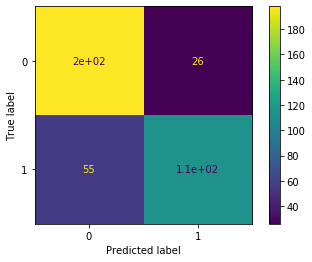

In [27]:
plot_confusion_matrix(gsld, x_test, y_test)

### 8 - Regression logistique

In [24]:
clflr = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', LogisticRegression())])

# clf.fit(x_train, y_train.values.ravel())
# clf
# print("model score : {}".format(clf.score(x_test, y_test)))

In [30]:
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__C': [0.1, 1.0, 10, 100],
    'classifier__max_iter': [1000, 10000]
}

clflr.fit(x_train, y_train.values.ravel())

grid_search = GridSearchCV(clflr, param_grid, cv=10)
grid_search.fit(x_train, y_train.values.ravel())
prediction = grid_search.predict(x_test)
print(("meilleur score de regression logistique: %.3f"
       % grid_search.score(x_test, y_test)))
print('f1 score : {}'.format(f1_score(y_test, prediction)))
print('recall : {}'.format(recall_score(y_test, prediction)))
print('meilleurs paramètres : {}'.format(grid_search.best_params_))

meilleur score de regression logistique: 0.949
f1 score : 0.9375
recall : 0.8875739644970414
meilleurs paramètres : {'classifier__C': 100, 'classifier__max_iter': 1000, 'preprocessor__num__imputer__strategy': 'mean'}


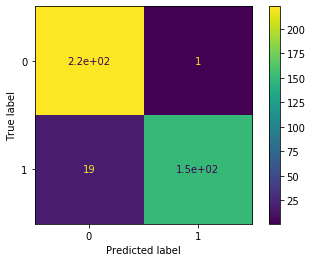

In [31]:
plot_confusion_matrix(grid_search, x_test, y_test)

### 9 - Arbre de décision

In [90]:
clfdt = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', DecisionTreeClassifier())])

params = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [4, 6, 8, 12]
}

clfdt.fit(x_train, y_train.values.ravel())

gsdt = GridSearchCV(estimator=clfdt, param_grid=params)
gsdt.fit(x_train, y_train.values.ravel())
prediction = gsdt.predict(x_test)
print("model score : {}".format(clfdt.score(x_test, y_test)))
print('f1 score : {}'.format(f1_score(y_test, prediction)))
print('recall : {}'.format(recall_score(y_test, prediction)))
print('meilleurs paramètres : {}'.format(gsdt.best_params_))

model score : 0.9134860050890585
f1 score : 0.9329268292682927
recall : 0.9053254437869822
meilleurs paramètres : {'classifier__criterion': 'entropy', 'classifier__max_depth': 6, 'preprocessor__num__imputer__strategy': 'median'}


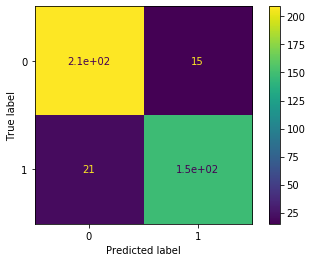

In [34]:
plot_confusion_matrix(clfdt, x_test, y_test)

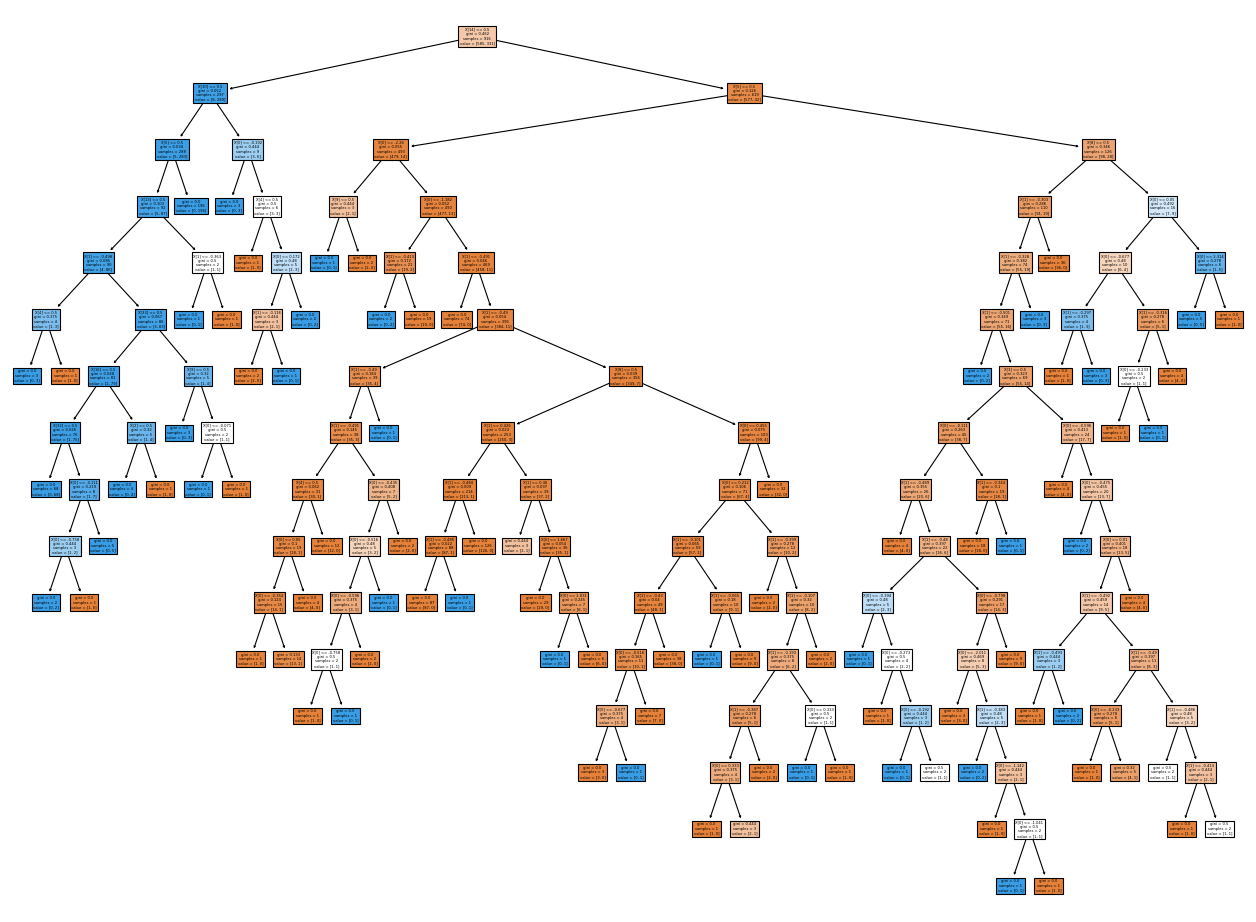

In [35]:
plt.figure(figsize=(20,15), dpi=80)
tree.plot_tree(gsdt.estimator['classifier'], filled=True)
plt.show()

### 10 - Voting classifier
(attention celui-là il fait siffler le PC)

In [ ]:
clfvc = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', VotingClassifier(estimators=[
                         ("clfknn", KNeighborsClassifier()),
                         ("clfsvm", SVC()),
                         ("clfld", LinearDiscriminantAnalysis()),
                         ("clflr", LogisticRegression()),
                         ("clfdt", DecisionTreeClassifier())
                     ]))])

params = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'preprocessor__sparse_threshold': [0],
    'classifier__clfknn__n_neighbors': list(range(1, 31)),
    'classifier__clfknn__weights': ['uniform', 'distance'],
    'classifier__clfsvm__kernel': ['rbf', 'linear', 'sigmoid', 'poly'],
    'classifier__clfsvm__C': [1, 10],
    'classifier__clfld__n_components': [1],
    'classifier__clflr__C': [0.1, 1.0, 10, 100],
    'classifier__clflr__max_iter': [1000, 10000],
    'classifier__clfdt__criterion': ['gini', 'entropy'],
    'classifier__clfdt__max_depth': [4, 6, 8, 12]
    
}

gsvc =  GridSearchCV(estimator=clfvc, param_grid=params)

gsvc.fit(x_train, y_train.values.ravel())
prediction = gsvc.predict(x_test)
print("model score : {}".format(clfvc.score(x_test, y_test)))
print('f1 score : {}'.format(f1_score(y_test, prediction)))
print('recall : {}'.format(recall_score(y_test, prediction)))
print('meilleurs paramètres : {}'.format(gsvc.best_params_))

### 11 - Random forest

In [47]:
clfrf = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', RandomForestClassifier())])

params = {
#     j'ai retiré des valeurs car celui-ci est assez long aussi
    'classifier__n_estimators': [200, 500],
    'classifier__max_depth': [5, 8],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

clfrf.fit(x_train, y_train.values.ravel())

gsrf = GridSearchCV(estimator=clfrf, param_grid=params)
gsrf.fit(x_train, y_train.values.ravel())
prediction = gsrf.predict(x_test)

print("model score : {}".format(clfrf.score(x_test, y_test)))

model score : 0.9465648854961832


In [38]:
print('f1 score : {}'.format(f1_score(y_test, prediction)))
print('recall : {}'.format(recall_score(y_test, prediction)))
print('meilleurs paramètres : {}'.format(gsrf.best_params_))

f1 score : 0.9320987654320988
recall : 0.893491124260355
meilleurs paramètres : {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 500}


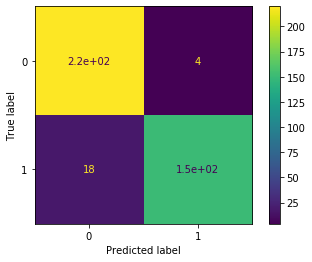

In [39]:
plot_confusion_matrix(gsrf, x_test, y_test)

### 12 - Gradient boosting

In [ ]:
clfgb = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', GradientBoostingClassifier())])

params = {
    "classifier__loss":["deviance"],
    "classifier__learning_rate": [0.025, 0.05,0.1, 0.2],
    "classifier__min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "classifier__max_depth":[8],
    "classifier__subsample":[0.5, 0.8, 1.0],
    "classifier__n_estimators":[10]
}

clfgb.fit(x_train, y_train.values.ravel())
gsgb = GridSearchCV(estimator=clfgb, param_grid=params)
gsgb.fit(x_train, y_train.values.ravel())
prediction = gsgb.predict(x_test)
print("model score : {}".format(clfgb.score(x_test, y_test)))
print('f1 score : {}'.format(f1_score(y_test, prediction)))
print('recall : {}'.format(recall_score(y_test, prediction)))
print('meilleurs paramètres : {}'.format(gsgb.best_params_))

### 13 - AdaBoost

In [47]:
clfab = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', AdaBoostClassifier())])

params = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    "classifier__n_estimators": [1, 10, 100]
}

clfab.fit(x_train, y_train.values.ravel())
gsab = GridSearchCV(estimator=clfab, param_grid=params)
gsab.fit(x_train, y_train.values.ravel())
prediction = gsab.predict(x_test)

print("model score : {}".format(clfab.score(x_test, y_test)))
print('f1 score : {}'.format(f1_score(y_test, prediction)))
print('recall : {}'.format(recall_score(y_test, prediction)))
print('meilleurs paramètres : {}'.format(gsab.best_params_))

model score : 0.9567430025445293
f1 score : 0.9341692789968652
recall : 0.8816568047337278
meilleurs paramètres : {'classifier__n_estimators': 1, 'preprocessor__num__imputer__strategy': 'mean'}


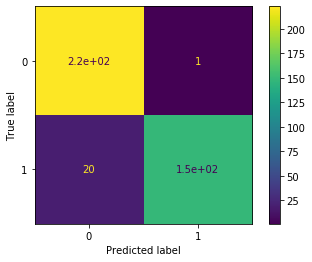

In [58]:
plot_confusion_matrix(gsab, x_test, y_test)

---
alt text